Image ./cv08_im1.bmp
Regions found 4
Centroids [[230, 34], [64, 205], [233, 212]]


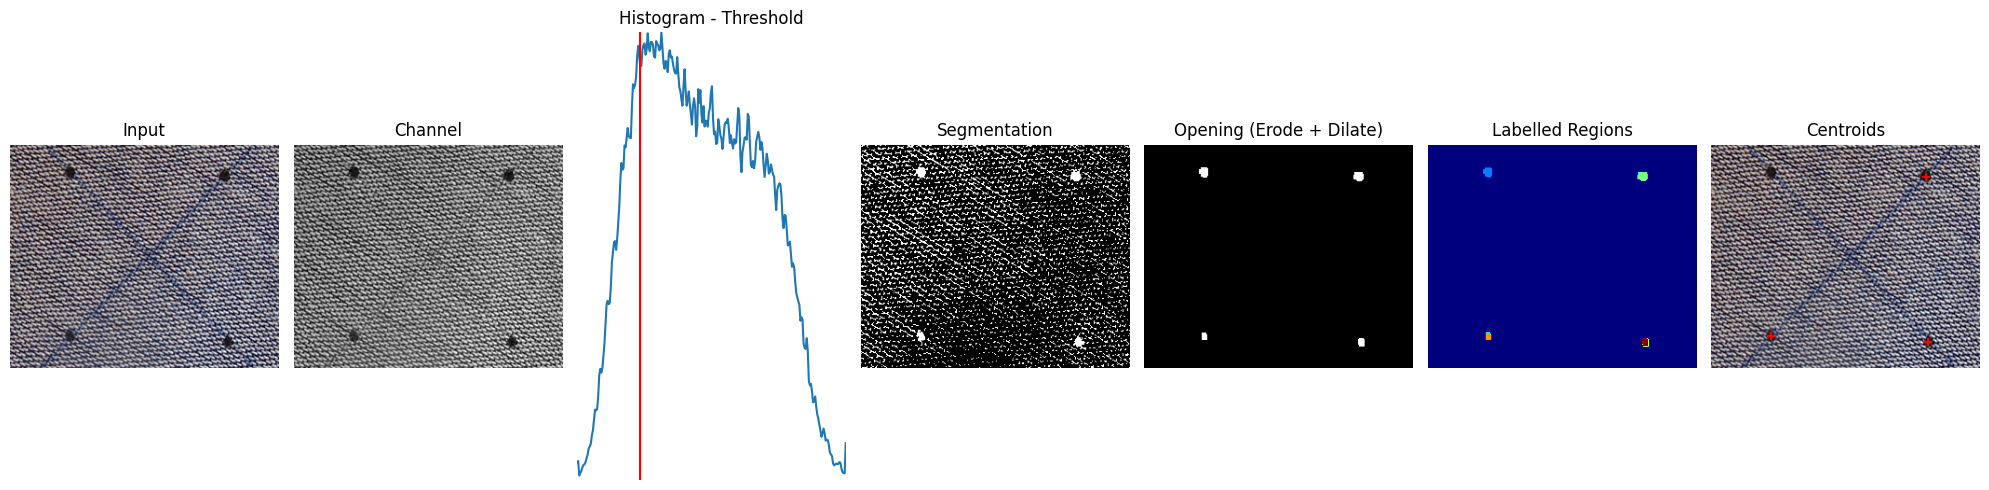

Image ./cv08_im2.bmp
Regions found 4
Centroids [[197, 34], [197, 192], [38, 195]]


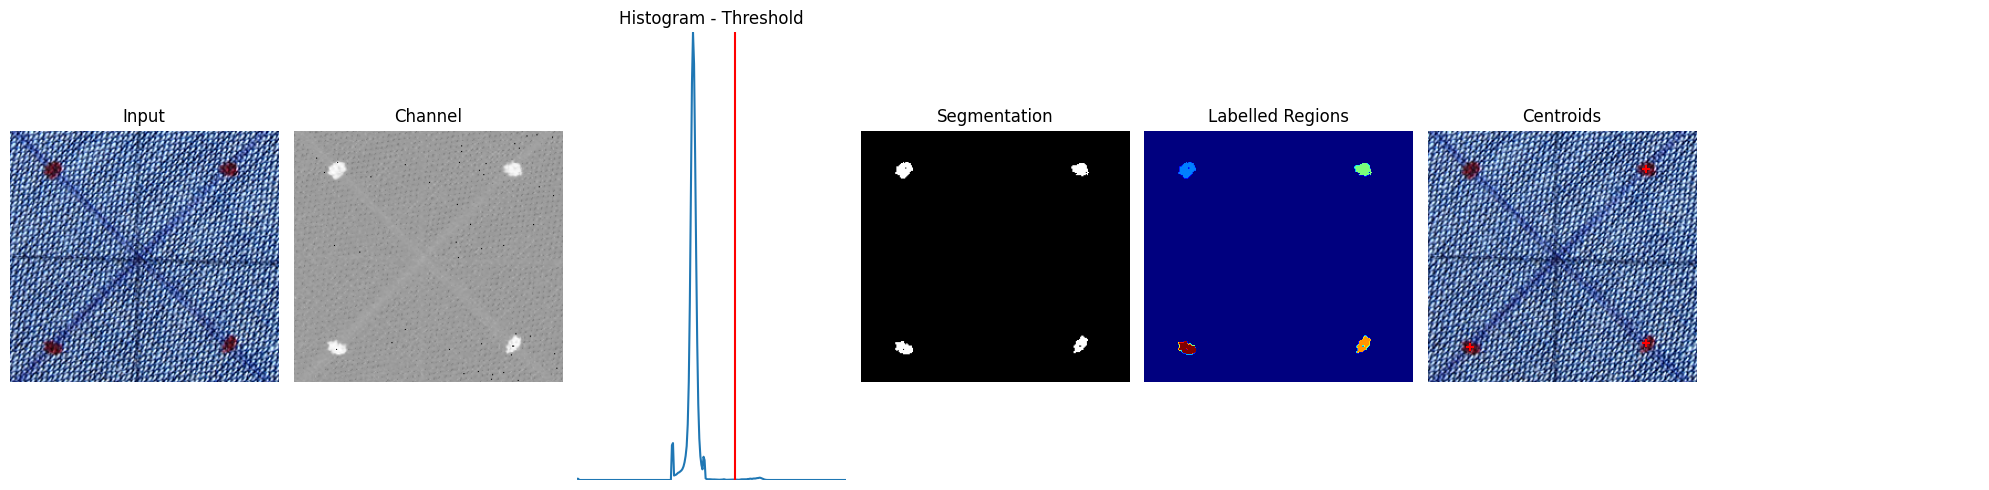

In [11]:
from pathlib import Path
from collections import deque
from tabulate import tabulate

import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_smooth_histogram(image: np.ndarray, smooth_factor: int = 1) -> np.ndarray:
    """
        Calculate and return a smoothed histogram for a given image.
    
        Args:
            image (np.ndarray): Input image as a NumPy array.
            smooth_factor (int): Smoothing factor determines the width of the smoothing window.
    
        Returns:
            np.ndarray: Smoothed histogram as a NumPy array.
        """
    # Calculate the histogram for the image
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Normalize the histogram to the range 0-255
    normalized_histogram = (histogram / histogram.max()) * 255

    # Flatten the histogram array
    flat_histogram = normalized_histogram.flatten()

    # Apply convolution to smooth the histogram
    smoothing_window = np.ones(smooth_factor) / smooth_factor
    smooth_histogram = np.convolve(flat_histogram, smoothing_window, mode='same')

    return smooth_histogram

def calculate_region_centroids(segmented_image: np.ndarray) -> list[list[int]]:
    """
    Calculate the centroids of labeled regions in a segmented image.

    This function computes the centroids of all labeled regions in a binary segmented image,
    excluding the background which is labeled as 0.

    Args:
        segmented_image (np.ndarray): An image array where different regions are labeled with integers.

    Returns:
        list: A list of centroids, where each centroid is represented as [x, y].

    Raises:
        ValueError: If any region has a zero area which would cause division by zero.
    """

    if np.max(segmented_image) == 0:
        raise ValueError("The segmented image contains no objects to process.")

    centroids = []

    # Start from 2 as 0 and 1 are typically background and border labels in segmented images
    for label in range(2, np.max(segmented_image) + 1):
        mask = np.zeros_like(segmented_image)
        mask[segmented_image == label] = 1

        # Calculate moments for the current region
        moments = cv2.moments(mask, binaryImage=True)

        # Check for zero area to avoid division by zero
        if moments['m00'] == 0:
            raise ValueError(f"Region with label {label} has zero area, can't compute centroid.")

        # Calculate centroid coordinates
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])

        centroids.append([cx, cy])

    return centroids

def label_image_regions(image):
    """
    Label connected regions in a binary image using breadth-first search (BFS).

    Args:
        image (np.ndarray): A binary image where foreground pixels are 1 and background pixels are 0.

    Returns:
        np.ndarray: An image with labeled regions, where each connected component has a unique integer label.
    """
    rows, cols = image.shape
    visited = np.zeros_like(image, dtype=bool)
    labels = np.zeros_like(image, dtype=int)

    # Directions for moving in the image (right, left, down, up)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def is_within_bounds(x, y):
        """Check if the coordinates are within the image bounds."""
        return 0 <= x < rows and 0 <= y < cols

    def bfs(start_x, start_y, label):
        """Perform BFS from the start point and label all connected pixels."""
        queue = deque([(start_x, start_y)])
        visited[start_x][start_y] = True
        labels[start_x][start_y] = label

        while queue:
            x, y = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if is_within_bounds(nx, ny) and not visited[nx][ny] and image[nx][ny] == 1:
                    queue.append((nx, ny))
                    visited[nx][ny] = True
                    labels[nx][ny] = label

    label_count = 1
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                bfs(i, j, label_count)
                label_count += 1

    return labels

def process_image(path, channel, threshold, kernel_size, row, cols):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    channel_data = image[:, :, channel]
    histogram = compute_smooth_histogram(channel_data, 2)

    segmented = (channel_data <= threshold).astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, kernel)

    regions = label_image_regions(opened)
    points = calculate_region_centroids(regions)

    print("Image", path)
    print("Regions found", np.max(regions))
    print("Centroids", points)

    fig, axes = plt.subplots(1, cols, figsize=(20, 5))  # Adjust overall figure size
    axes[0].imshow(image)
    axes[0].set_title("Input")

    axes[1].imshow(channel_data, cmap="gray")
    axes[1].set_title("Channel")

    axes[2].plot(histogram)
    axes[2].vlines([threshold], 0, max(histogram), "red")
    axes[2].set_xlim(0, 255)
    axes[2].set_ylim(0, max(histogram))
    axes[2].set_title("Histogram - Threshold")

    axes[3].imshow(segmented, cmap="gray")
    axes[3].set_title("Segmentation")

    axes[4].imshow(opened, cmap="gray")
    axes[4].set_title("Opening (Erode + Dilate)")

    axes[5].imshow(regions / np.max(regions) * 255, cmap='jet')
    axes[5].set_title("Labelled Regions")

    axes[6].imshow(image)
    axes[6].scatter(*zip(*points), marker="+", color="red")
    axes[6].set_title("Centroids")

    for ax in axes:
        ax.axis('off')  # Hide axes for cleaner visualization

    plt.tight_layout()
    plt.show()

def process_image_2(path, channel, threshold, kernel_size, row, cols):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV color space
    channel_data = image[:, :, channel]  # Work with the specified channel
    histogram = compute_smooth_histogram(channel_data, 2)

    segmented = (channel_data > threshold).astype(np.uint8)  # Threshold the channel

    regions = label_image_regions(segmented)
    points = calculate_region_centroids(regions)

    print("Image", path)
    print("Regions found", np.max(regions))
    print("Centroids", points)

    fig, axes = plt.subplots(1, cols, figsize=(20, 5))  # Adjust overall figure size
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))  # Show the HSV image in RGB
    axes[0].set_title("Input")

    axes[1].imshow(channel_data, cmap="gray")
    axes[1].set_title("Channel")

    axes[2].plot(histogram)
    axes[2].vlines([threshold], 0, max(histogram), "red")
    axes[2].set_xlim(0, 255)
    axes[2].set_ylim(0, max(histogram))
    axes[2].set_title("Histogram - Threshold")

    axes[3].imshow(segmented, cmap="gray")
    axes[3].set_title("Segmentation")

    axes[4].imshow(regions / np.max(regions) if np.max(regions) > 0 else regions, cmap='jet')  # Normalize if not zero
    axes[4].set_title("Labelled Regions")

    axes[5].imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))  # Show the centroids on the original image
    axes[5].scatter(*zip(*points), marker="+", color="red")
    axes[5].set_title("Centroids")

    for ax in axes:
        ax.axis('off')  # Hide axes for cleaner visualization

    plt.tight_layout()
    plt.show()

# Setup
rows = 2
cols = 7

# Call the process functions
process_image("./cv08_im1.bmp", 2, 60, 5, 0, cols)
process_image_2("./cv08_im2.bmp", 0, 150, 3, 1, cols)

  

-------------  --------------------------------------------
Image          ./cv08_im1.bmp
Regions found  4
Centroids      [[63, 29], [230, 34], [64, 205], [233, 212]]
-------------  -------------------------------------------- 


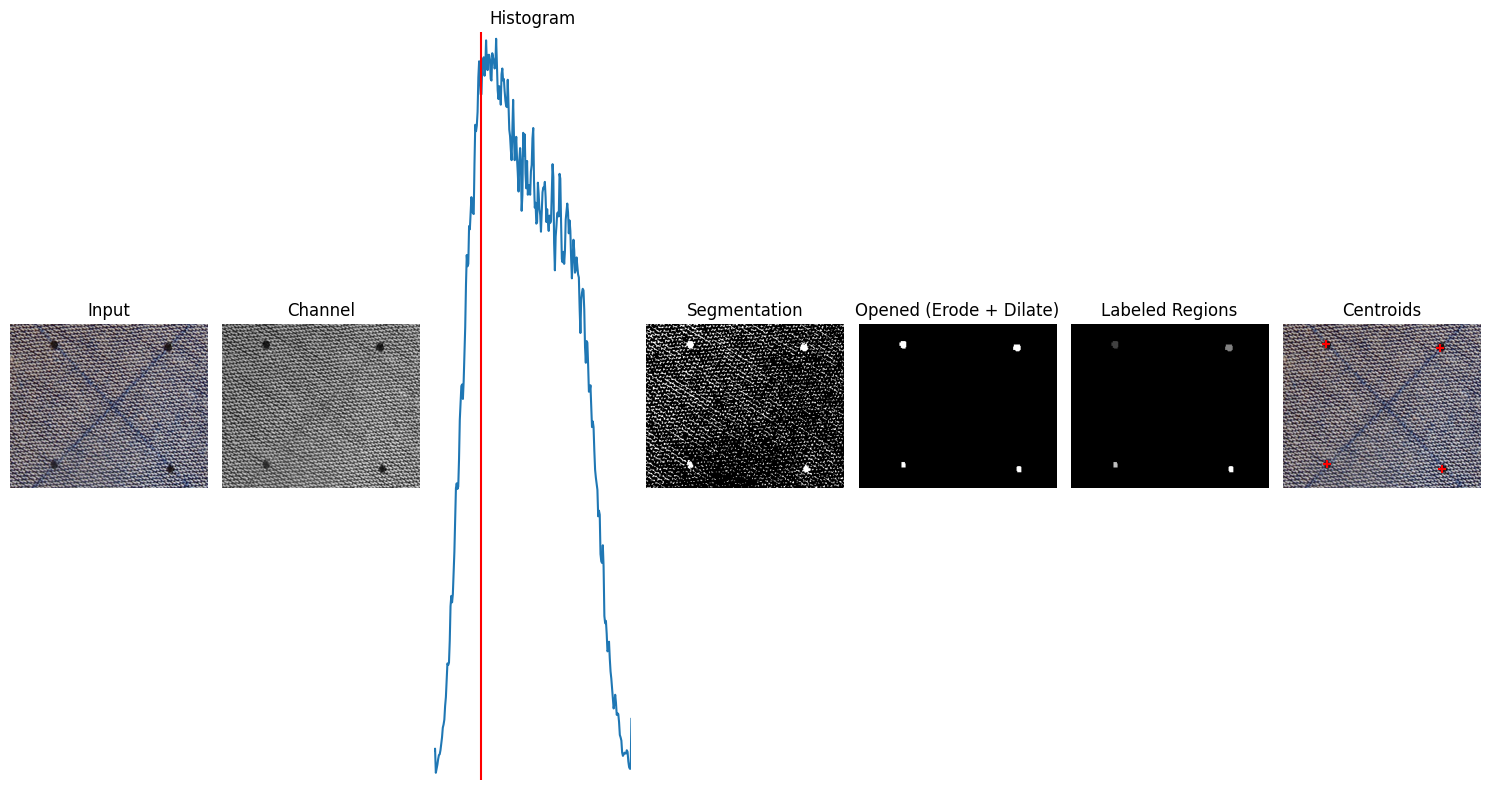

-------------  --------------
Image          ./cv08_im2.bmp
Regions found  1
Centroids      [[121, 113]]
-------------  -------------- 


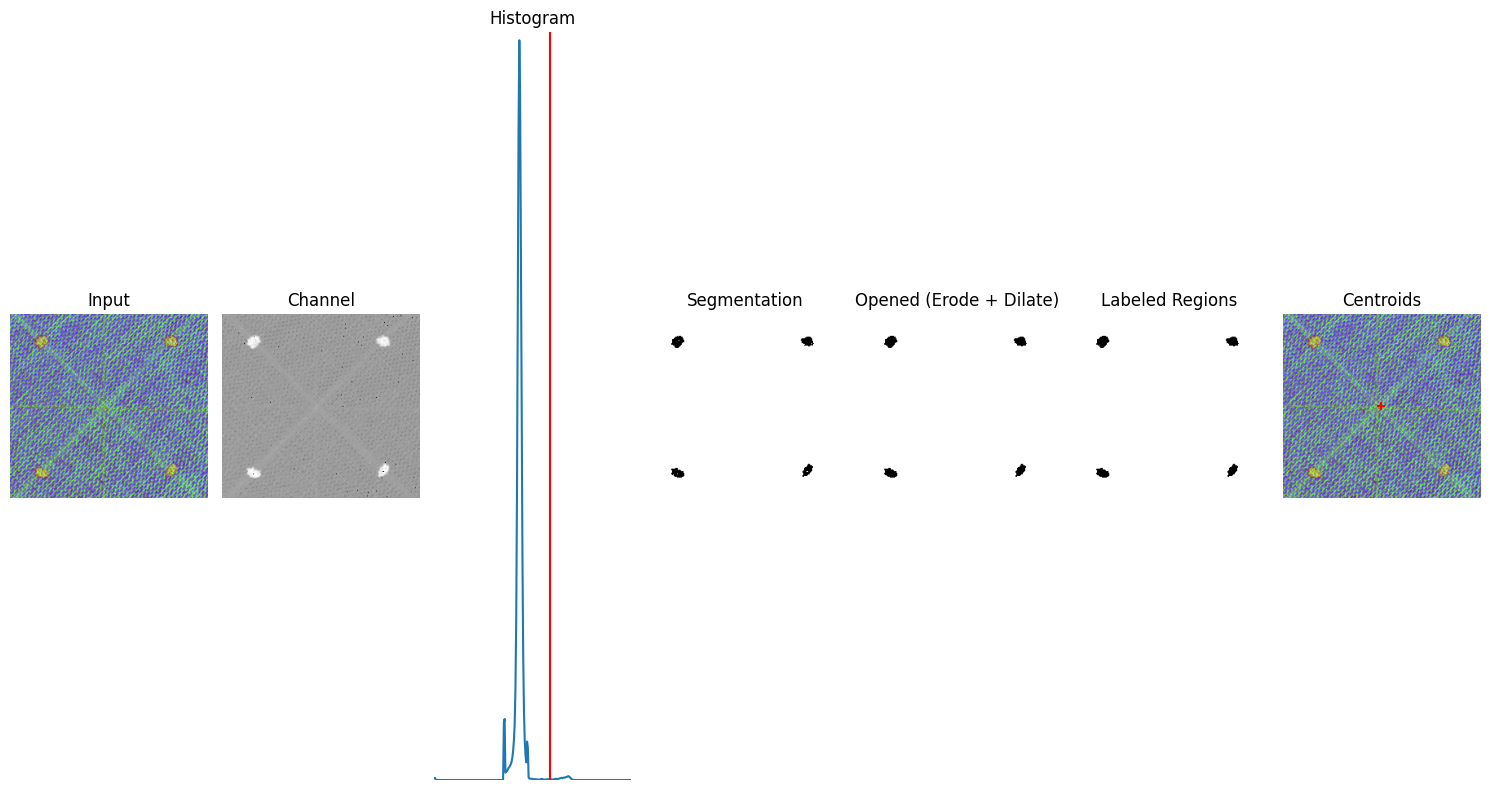

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque
from tabulate import tabulate


def get_histogram(image, smoothing=2):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    normalized = histogram / np.max(histogram) * 255
    flattened = np.ndarray.flatten(normalized)
    smoothed = np.convolve(flattened, np.ones(smoothing) / smoothing, mode='same')
    return smoothed


class ImageAnalyzer:
    def __init__(self, path, channel, threshold, kernel_size, row, cols):
        self.path = path
        self.channel = channel
        self.threshold = threshold
        self.kernel_size = kernel_size
        self.row = row
        self.cols = cols
        self.image = cv2.imread(Path(self.path).as_posix())
        if self.image is None:
            raise FileNotFoundError(f"No image found at {self.path}")
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB if 'im1' in self.path else cv2.COLOR_BGR2HSV)

    def get_centers_of_mass(self, image):
        points = []
        for i in range(1, np.max(image) + 1):
            copy = np.zeros_like(image)
            copy[image == i] = 1
            moments = cv2.moments(copy, True)
            if moments['m00'] != 0:
                points.append([int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])])
        return points

    def bfs_coloring(self, image):
        rows, cols = image.shape
        visited = np.zeros_like(image).astype("bool")
        colors = np.zeros_like(image).astype("uint8")
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        def is_valid(x, y):
            return 0 <= x < rows and 0 <= y < cols
        def bfs(x, y, color):
            queue = deque([(x, y)])
            visited[x][y] = True
            colors[x][y] = color
            while queue:
                current_x, current_y = queue.popleft()
                for dx, dy in directions:
                    new_x, new_y = current_x + dx, current_y + dy
                    if is_valid(new_x, new_y) and not visited[new_x][new_y] and image[new_x][new_y] == 1:
                        queue.append((new_x, new_y))
                        visited[new_x][new_y] = True
                        colors[new_x][new_y] = color
        color_count = 0
        for i in range(rows):
            for j in range(cols):
                if not visited[i][j] and image[i][j] == 1:
                    color_count += 1
                    bfs(i, j, color_count)
        return colors

    def process_and_display(self):
        channel_data = self.image[:, :, self.channel].astype(np.uint8)
        histogram = get_histogram(channel_data)
        segmented = np.where(channel_data <= self.threshold, 1, 0).astype(np.uint8)
        kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

        # Perform erosion followed by dilation
        eroded = cv2.erode(segmented, kernel)
        opened = cv2.dilate(eroded, kernel)

        regions = self.bfs_coloring(opened)
        points = self.get_centers_of_mass(regions)
        print(tabulate([
            ["Image", self.path],
            ["Regions found", np.max(regions)],
            ["Centroids", points]
        ]), "\n")
        self.display_images(self.image, channel_data, histogram, segmented, opened, regions, points)

    def display_images(self, image, channel_data, histogram, segmented, opened, regions, points):
        plt.figure(figsize=(15, 8))  # Set overall figure size
        plot_data = [
            (image, "Input"),
            (channel_data, "Channel"),
            (histogram, "Histogram"),
            (segmented, "Segmentation"),
            (opened, "Opened (Erode + Dilate)"),
            (regions / np.max(regions) * 255, "Labeled Regions"),
            (image, "Centroids", points)
        ]
        for i, (img, title, *scatter) in enumerate(plot_data, 1):
            ax = plt.subplot(1, len(plot_data), i)
            if title == "Histogram":
                ax.plot(img)
                ax.set_xlim(0, 255)
                ax.set_ylim(0, 255)
                ax.vlines([self.threshold], 0, 255, "red")
            elif title == "Centroids":
                ax.imshow(img)
                ax.scatter(*zip(*scatter[0]), marker="+", color="red")
            else:
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage
analyzer1 = ImageAnalyzer("./cv08_im1.bmp", 2, 60, 5, 0, 7)
analyzer1.process_and_display()
analyzer2 = ImageAnalyzer("./cv08_im2.bmp", 0, 150, 3, 1, 7)
analyzer2.process_and_display()


-------------  --------------------------------------------
Image          ./cv08_im1.bmp
Regions found  4
Centroids      [[63, 29], [230, 34], [64, 205], [233, 212]]
-------------  -------------------------------------------- 


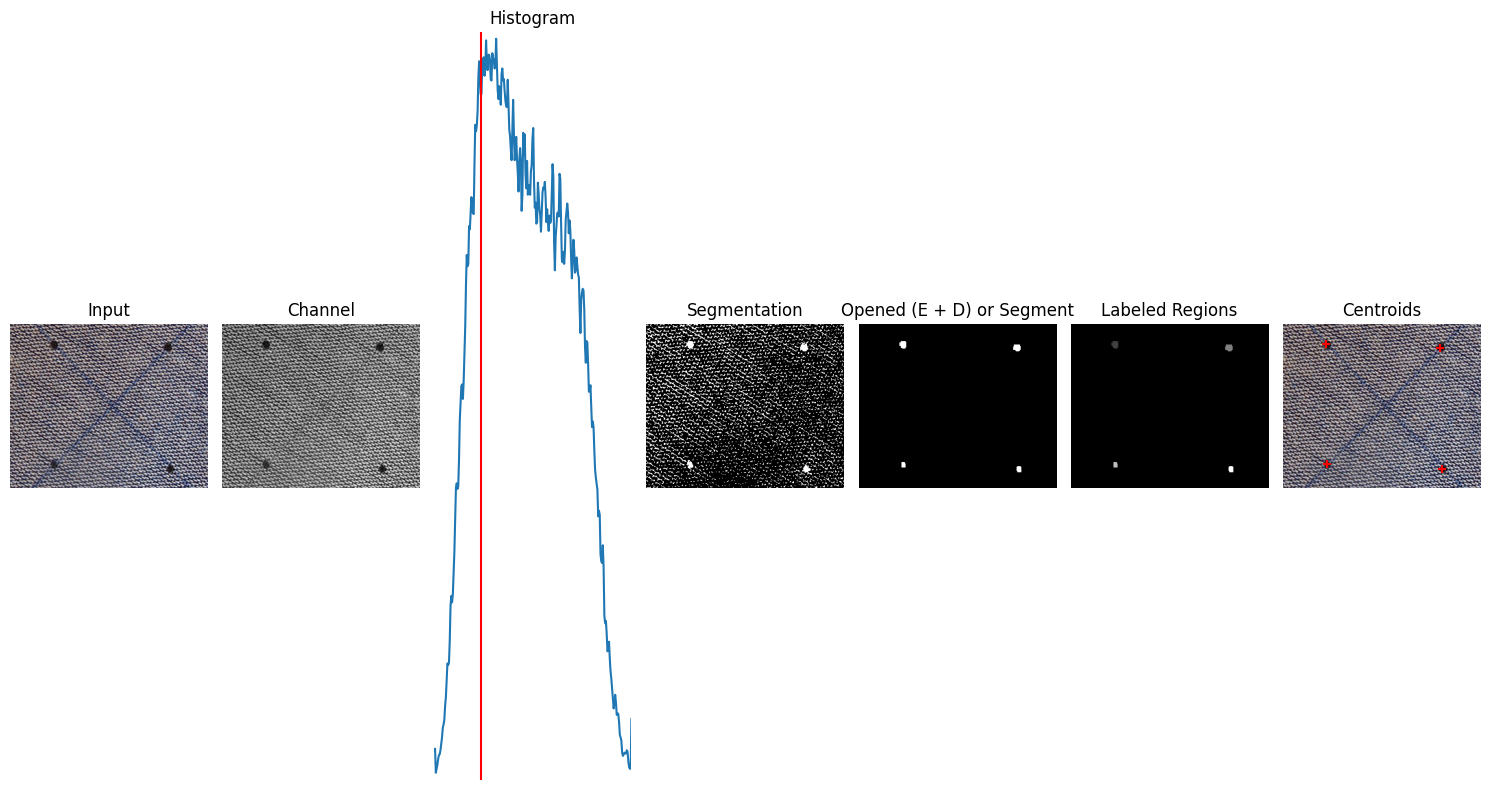

-------------  --------------------------------------------
Image          ./cv08_im2.bmp
Regions found  4
Centroids      [[38, 34], [197, 34], [197, 192], [38, 195]]
-------------  -------------------------------------------- 


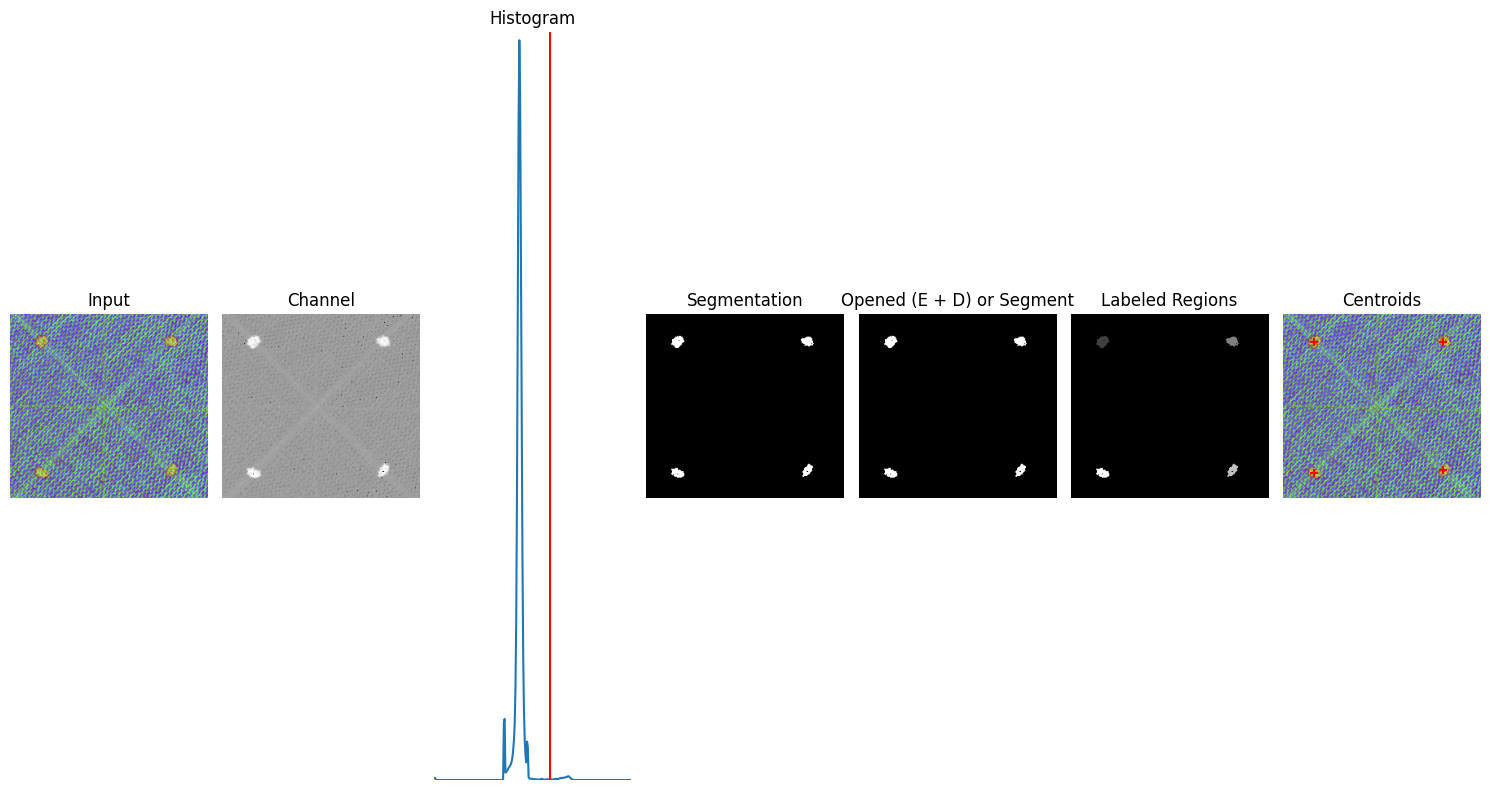

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque
from tabulate import tabulate

class ImageAnalyzer:
    def __init__(self, path, channel, threshold, kernel_size, row, cols):
        self.path = path
        self.channel = channel
        self.threshold = threshold
        self.kernel_size = kernel_size
        self.row = row
        self.cols = cols
        self.image = cv2.imread(Path(self.path).as_posix())
        if self.image is None:
            raise FileNotFoundError(f"No image found at {self.path}")
        # Adjust color conversion based on the file name or other identifier
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB if 'im1' in self.path else cv2.COLOR_BGR2HSV)

    def get_histogram(self, image, smoothing=2):
        histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
        normalized = histogram / np.max(histogram) * 255
        flattened = np.ndarray.flatten(normalized)
        smoothed = np.convolve(flattened, np.ones(smoothing) / smoothing, mode='same')
        return smoothed

    def get_centers_of_mass(self, image):
        points = []
        for i in range(1, np.max(image) + 1):
            copy = np.zeros_like(image)
            copy[image == i] = 1
            moments = cv2.moments(copy, True)
            if moments['m00'] != 0:
                points.append([int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])])
        return points

    def bfs_coloring(self, image):
        rows, cols = image.shape
        visited = np.zeros_like(image).astype("bool")
        colors = np.zeros_like(image).astype("uint8")
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        def is_valid(x, y):
            return 0 <= x < rows and 0 <= y < cols
        def bfs(x, y, color):
            queue = deque([(x, y)])
            visited[x][y] = True
            colors[x][y] = color
            while queue:
                current_x, current_y = queue.popleft()
                for dx, dy in directions:
                    new_x, new_y = current_x + dx, current_y + dy
                    if is_valid(new_x, new_y) and not visited[new_x][new_y] and image[new_x][new_y] == 1:
                        queue.append((new_x, new_y))
                        visited[new_x][new_y] = True
                        colors[new_x][new_y] = color
        color_count = 0
        for i in range(rows):
            for j in range(cols):
                if not visited[i][j] and image[i][j] == 1:
                    color_count += 1
                    bfs(i, j, color_count)
        return colors

    def process_and_display(self):
        channel_data = self.image[:, :, self.channel].astype(np.uint8)
        histogram = get_histogram(channel_data)
        segmented = np.where(channel_data <= self.threshold, 1, 0).astype(np.uint8)
        kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

        # Perform erosion followed by dilation
        eroded = cv2.erode(segmented, kernel)
        opened = cv2.dilate(eroded, kernel)

        regions = self.bfs_coloring(opened)
        points = self.get_centers_of_mass(regions)
        print(tabulate([
            ["Image", self.path],
            ["Regions found", np.max(regions)],
            ["Centroids", points]
        ]), "\n")
        self.display_images(self.image, channel_data, histogram, segmented, opened, regions, points)

    def process_image_2(self):
        # Specific processing for the second image type
        channel_data = self.image[:, :, 0]  # Assuming the first channel for HSV
        histogram = self.get_histogram(channel_data)
        segmented = np.where(channel_data > self.threshold, 1, 0).astype(np.uint8)
        regions = self.bfs_coloring(segmented)
        points = self.get_centers_of_mass(regions)
        print(tabulate([
            ["Image", self.path],
            ["Regions found", np.max(regions)],
            ["Centroids", points]
        ]), "\n")
        self.display_images(self.image, channel_data, histogram, segmented, None, regions, points)

    def display_images(self, image, channel_data, histogram, segmented, opened, regions, points):
        plt.figure(figsize=(15, 8))  # Set overall figure size
        plot_data = [
            (image, "Input"),
            (channel_data, "Channel"),
            (histogram, "Histogram"),
            (segmented, "Segmentation"),
            (opened if opened is not None else segmented, "Opened (E + D) or Segment"),
            (regions / np.max(regions) * 255, "Labeled Regions"),
            (image, "Centroids", points)
        ]
        for i, (img, title, *scatter) in enumerate(plot_data, 1):
            ax = plt.subplot(1, len(plot_data), i)
            if title == "Histogram":
                ax.plot(img)
                ax.set_xlim(0, 255)
                ax.set_ylim(0, 255)
                ax.vlines([self.threshold], 0, 255, "red")
            elif title == "Centroids":
                ax.imshow(img)
                ax.scatter(*zip(*scatter[0]), marker="+", color="red")
            else:
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage
analyzer1 = ImageAnalyzer("./cv08_im1.bmp", 2, 60, 5, 0, 7)
analyzer1.process_and_display()  # This would process using the default method for first image type

analyzer2 = ImageAnalyzer("./cv08_im2.bmp", 0, 150, 3, 1, 7)
analyzer2.process_image_2()  # This processes using the specific method for the second image type
